In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim

# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, plot_latent_space_no_labels, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
batch_size = 128
optimizer = torch.optim.Adam

In [16]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 20
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 20
    step_config = {
        "step_size" : -1,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }
elif dataset == "LFW":
    epochs = 40 #0
    hidden_dim = 700 # 200 in Kingma for Frey Face but we have highly varying data!
    z_dim = 20
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": 1e-5
    }
elif dataset == "FF":
    epochs = 100 # 200 for zdim=20, 500 for zdim=2
    hidden_dim = 200 # as in Kingma
    z_dim = 2
    step_config = {
        "step_size" : 100,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }

In [17]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
encoder = Encoder(data_loader.input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, data_loader.input_dim)
model = Vae(encoder, decoder)

In [ ]:
solver = Solver(model, data_loader, optimizer, z_dim, epochs, step_config, optim_config)
solver.run()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 459.8507
====> Test set loss avg: 405.2754
43.30969715118408 seconds for epoch 1
====> Epoch: 2 train set loss avg: 345.0615
====> Test set loss avg: 324.1490
53.29443550109863 seconds for epoch 2
====> Epoch: 3 train set loss avg: 275.6801
====> Test set loss avg: 277.2573
52.148908615112305 seconds for epoch 3
====> Epoch: 4 train set loss avg: 230.0838
====> Test set loss avg: 241.3328
51.46807360649109 seconds for epoch 4


In [172]:
# Insert name of model here if want to load a model, e.g. "../models/VAE_MNIST_train_loss=151.39_z=2.pt"
#solver = torch.load()
#solver.model.eval()

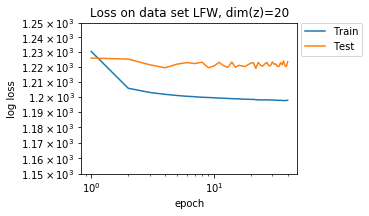

In [7]:
# Plotting train and test losses for all epochs
if dataset == "MNIST":
    plot_losses(solver, (100, 210, 10))
if dataset == "FF":
    plot_losses(solver, (330, 410, 10))
if dataset == "LFW":
    plot_losses(solver, (1150, 1260, 10))

epoch: 1, mu(z): 0.0015, stddev(z): 1.2368, var(z): 1.5296, var(mu(z)): 0.2998 E[var(q(z|x)]: 3.8895
epoch: 25, mu(z): -0.0037, stddev(z): 1.0420, var(z): 1.0858, var(mu(z)): 0.9599 E[var(q(z|x)]: 0.0106
epoch: 50, mu(z): 0.0024, stddev(z): 1.0266, var(z): 1.0539, var(mu(z)): 0.9383 E[var(q(z|x)]: 0.0086
epoch: 100, mu(z): 0.0001, stddev(z): 1.0130, var(z): 1.0262, var(mu(z)): 0.9480 E[var(q(z|x)]: 0.0067


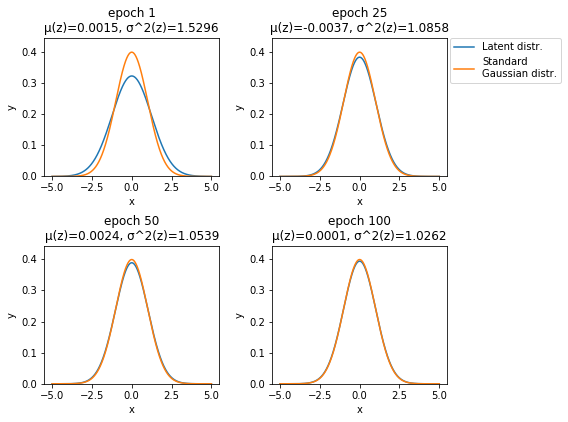

In [15]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
plot_gaussian_distributions(solver)

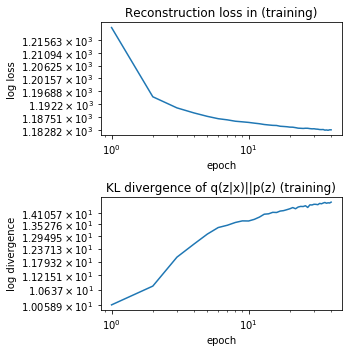

In [9]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
if dataset == "MNIST" and z_dim == 2:
    plot_rl_kl(solver, 5, 20)
if dataset == "MNIST" and z_dim == 20:
    plot_rl_kl(solver, 5, 20)
if dataset == "FF" and z_dim == 2:
    plot_rl_kl(solver, 10, 15)
if dataset == "LFW" and z_dim == 20:
    plot_rl_kl(solver, 5, 5)

In [242]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2:
    if solver.loader.dataset != "FF":
        plot_latent_space(solver)
    else:
        plot_latent_space_no_labels(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

Plot of latent space not possible as dimension of z is not 2


In [243]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.loader.dataset == "MNIST":
        plot_latent_manifold(solver, "bone")
    if solver.loader.dataset == "LFW" or solver.loader.dataset == "FF":
        plot_latent_manifold(solver, "gray", n=10, fig_size=(10, 8))
else:
    print("Plot is not possible as dimension of z is not 2")

Plot is not possible as dimension of z is not 2


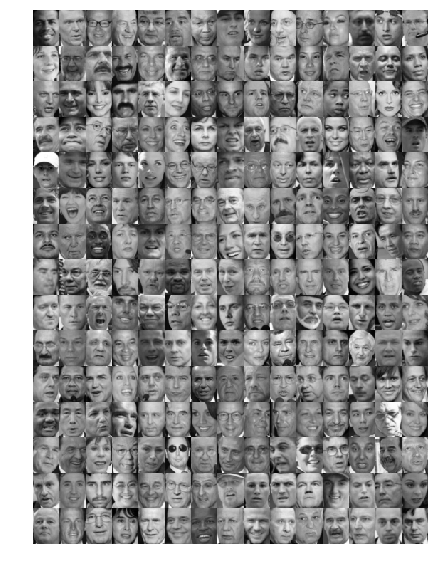

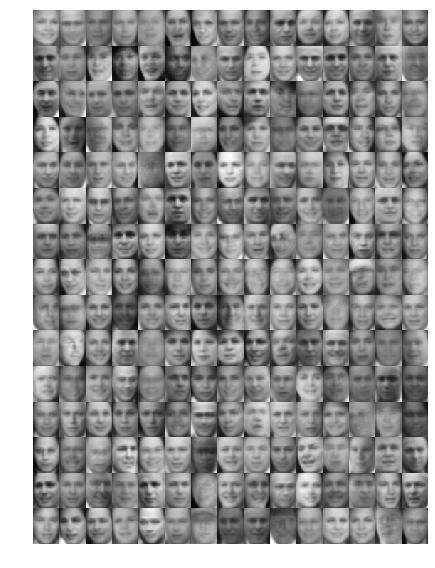

In [10]:
# plots real faces and in grid samples
if dataset == "LFW" or dataset == "FF":
    plot_faces_grid(225, 15, solver)
    plot_faces_samples_grid(225, 15, solver)

In [222]:
avg_train_loss = np.array(solver.train_loss_history["train_loss_acc"]).mean()
torch.save(solver, "../models/VAE_" + solver.loader.dataset + "_train_loss=" + "{0:.2f}".format(avg_train_loss) + "_z=" + str(solver.z_dim) + ".pt")

PicklingError: Can't pickle <class 'solver.Solver'>: it's not the same object as solver.Solver